In [1]:
import os
import pickle
import shutil 

import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from IPython import embed

Using MPI version 4.0, 1 processes


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
# set up simulation constants

resolution = 10

n_fusedSilica = 1.44
n_PDMS = 1.4
n_amorphousSi = 3.48

a = 0.680   # lattice period 

#pml_thickness = round(wavelength / 2,3)
pml_thickness = 0.780
height_pillar = 1.020
width_PDMS = 1.560
width_fusedSilica = 0.780

cell_x = a
cell_y = a
cell_z = round(2*pml_thickness + width_PDMS + height_pillar +  width_fusedSilica, 3)

center_PDMS = round(0.5*(height_pillar + width_PDMS + pml_thickness) 
                    + (pml_thickness + width_fusedSilica) - 0.5*cell_z, 3)
center_fusedSilica = round(0.5*(pml_thickness + width_fusedSilica) - 0.5*cell_z, 3)
center_pillar = round(pml_thickness + width_fusedSilica + 0.5*height_pillar
                    - 0.5*cell_z, 3) 

z_fusedSilica = pml_thickness + width_fusedSilica
z_PDMS = height_pillar + width_PDMS + pml_thickness

pillar_rad = 0.1625

In [3]:
geometry = [mp.Block(size=mp.Vector3(mp.inf,mp.inf,z_fusedSilica), 
                    center=mp.Vector3(0,0,center_fusedSilica),
                    material=mp.Medium(index=n_fusedSilica)),
            mp.Block(size=mp.Vector3(mp.inf,mp.inf,z_PDMS),
                    center=mp.Vector3(0,0,center_PDMS),
                    material=mp.Medium(index=n_PDMS)),
           mp.Cylinder(radius=pillar_rad,
                        height=height_pillar,
                        axis=mp.Vector3(0,0,1),
                        center=mp.Vector3(0,0,center_pillar),
                        material=mp.Medium(index=n_amorphousSi))]
k_point = mp.Vector3(0,0,0)

wavelength = 1.55
freq = 1 / wavelength

## initialize matrix for data collection ##
##########################################

num = 15 # this is the number of pillars we will build
data = np.zeros((3,num))

## set up and build source ##
############################

center_source = round(pml_thickness + width_fusedSilica*0.2 - 0.5*cell_z, 3) 
source_cmpt = mp.Ey

sources = [mp.Source(mp.ContinuousSource(frequency=freq),
                    component=source_cmpt,
                    center=mp.Vector3(0,0,center_source),
                    size=mp.Vector3(cell_x,cell_y,0))]


In [4]:
## Set up simulation ##
######################

cell_size = mp.Vector3(cell_x,cell_y,cell_z)
pml_layers = [mp.PML(thickness = pml_thickness, direction = mp.Z)]

if source_cmpt == mp.Ey:
    symmetries = [mp.Mirror(mp.X, phase=+1), #epsilon has mirror symmetry in x and y, phase doesn't matter
                  mp.Mirror(mp.Y, phase=-1)] #but sources have -1 phase when reflected normal to their direction
elif src_cmpt == mp.Ex:                      #use of symmetries important here, significantly speeds up sim
    symmetries = [mp.Mirror(mp.X, phase=-1),
                  mp.Mirror(mp.Y, phase=+1)]
elif src_cmpt == mp.Ez:
    symmetries = [mp.Mirror(mp.X, phase=+1),
                  mp.Mirror(mp.Y, phase=+1)]

sim = mp.Simulation(cell_size=cell_size,
                    geometry=geometry,
                    sources=sources,
                    k_point=k_point,
                    boundary_layers=pml_layers,
                    symmetries=symmetries,
                    resolution=resolution)

nfreq = 1
df = 0
# fr_center = round(0.5*cell_z - pml_thickness - 0.3*width_PDMS, 3)
# fr = mp.FluxRegion(center=mp.Vector3(0,0,fr_center), 
#             size=mp.Vector3(cell_x, cell_y, 0))

# flux_object = sim.add_flux(freq, df, nfreq, fr)
# print(fr_center)
sim.run(until=200)

-----------
Initializing structure...
Padding x to even number of grid points.
Padding y to even number of grid points.
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.0043509 s
Working in 3D dimensions.
Computational cell is 0.7 x 0.7 x 4.9 with resolution 10
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.1625, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
time for set_epsilon = 0.0324152 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (4000 timesteps)


/develop/build/miniconda3/envs/env/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/develop/build/miniconda3/envs/env/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.1625, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)


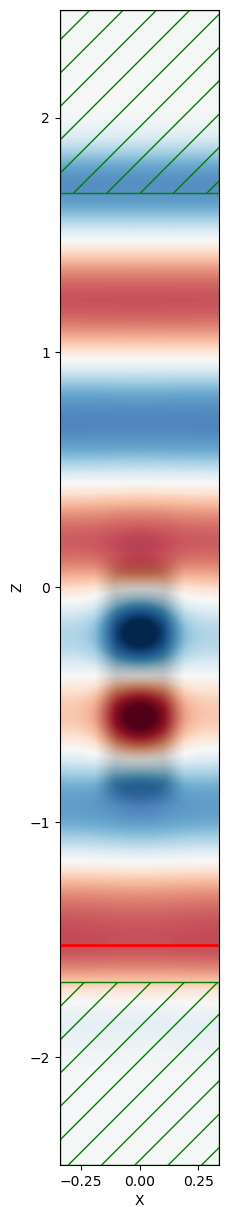

In [5]:
plt.figure(figsize=(15,15))
plot_plane = mp.Volume(center=mp.Vector3(0,0,0),
                            size=mp.Vector3(a,0,cell_z))
field_func = lambda x: 20*np.log10(np.abs(x))
test = sim.plot2D(output_plane=plot_plane,
           fields=mp.Ey
           )

In [6]:
font = {'size': 14}

def mod_axes(ax):
    ax.set_xlabel('X [$\mu$m]', fontdict=font)
    ax.set_ylabel('Z [$\mu$m]', fontdict=font)
    ax.tick_params(axis='both', labelsize=14)
    return ax
plot_modifiers=[mod_axes]

/develop/build/miniconda3/envs/env/lib/python3.10/site-packages/meep/visualization.py:1402: UserWarning: Warning: The 'sim' argument in Animate2D is deprecated and has no effect. It will be removed in a future release.
  warnings.warn(


FloatProgress(value=200.0, description='0% done ', max=300.0, min=200.0)

     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (0,0,-0.39)
          radius 0.1625, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
on time step 4000 (time=200), 0.00255874 s/step
Normalizing field data...
run 1 finished at t = 300.0 (6000 timesteps)


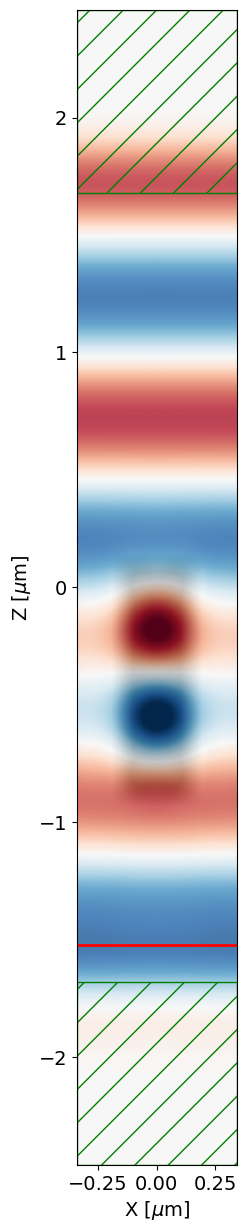

In [7]:
f = plt.figure(dpi=100, figsize=(8,15))
Animate = mp.Animate2D(sim=sim, output_plane=plot_plane, fields=mp.Ey, f=f, realtime=False, normalize=True, plot_modifiers=plot_modifiers)
sim.run(mp.at_every(0.1, Animate), until=100)

filename = "efields.mp4"

In [8]:
fps = 20
Animate.to_mp4(fps, filename)

Generating MP4...


BrokenPipeError: [Errno 32] Broken pipe